In [1]:
### FILTRAGE COLLABORATIF

import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD

In [18]:
# Charger/traiter les données
data = pd.read_csv('../data/raw/raw_recipes.csv')
data = data.drop_duplicates().dropna()
users = pd.read_csv('../data/raw/PP_users.csv')
users = users.drop_duplicates().dropna()
interactions = pd.read_csv('../data/raw/RAW_interactions.csv')
interactions = interactions.drop_duplicates().dropna()

# Filtrer les utilisateurs avec au moins 5 interactions
active_users = interactions['user_id'].value_counts()
filtered_users = active_users[active_users >= 5].index
interactions = interactions[interactions['user_id'].isin(filtered_users)]

# Filtrer les recettes avec au moins 5 interactions
popular_recipes = interactions['recipe_id'].value_counts()
filtered_recipes = popular_recipes[popular_recipes >= 5].index
interactions = interactions[interactions['recipe_id'].isin(filtered_recipes)]

print("\nNombre total de recettes après traitement :", data.shape[0])
print("\nNombre total d'utilisateurs après traitement :", users.shape[0])
print("\nNombre total d'interactions après traitement :", interactions.shape[0])


Nombre total de recettes après traitement : 226657

Nombre total d'utilisateurs après traitement : 25076

Nombre total d'interactions après traitement : 577065


In [21]:
# Créer un utilisateur fictif et lui attribuer des notes à 10 recettes
best_recipes = (
    interactions.groupby('recipe_id')['rating']
    .mean()
    .sort_values(ascending=False)
    .head(10)
    .index
)

new_user_id = users['u'].max() + 1  # Générer un nouvel ID
new_user_ratings = pd.DataFrame({
    'user_id': [new_user_id] * 10,
    'recipe_id': best_recipes,
    #'rating': [4, 3, 5, 2, 5, 1, 3, 4, 5, 5]
    'rating': [1, 5, 2, 5, 3, 5, 3, 2, 4, 2]
})

# Ajouter l'utilisateur fictif aux données d'interactions
interactions = pd.concat([interactions, new_user_ratings], ignore_index=True)

# Créer des mappings pour les utilisateurs et les recettes
user_mapping = {user_id: idx for idx, user_id in enumerate(interactions['user_id'].unique())}
recipe_mapping = {recipe_id: idx for idx, recipe_id in enumerate(interactions['recipe_id'].unique())}

# Mettre à jour les IDs dans les interactions
interactions['user_id'] = interactions['user_id'].map(user_mapping)
interactions['recipe_id'] = interactions['recipe_id'].map(recipe_mapping)

# Construire la matrice creuse
sparse_matrix = csr_matrix((
    interactions['rating'], 
    (interactions['user_id'], interactions['recipe_id'])
))

# Entraîner le modèle k-NN
knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
knn_model.fit(sparse_matrix)

TypeError: 'int' object is not subscriptable

In [4]:
def get_recommendations_knn(user_id, nResults, n_neighbors):
    user_idx = user_mapping[user_id]
    try:
        # Recherche des voisins
        distances, indices = knn_model.kneighbors(sparse_matrix[user_idx], n_neighbors=n_neighbors)
    except ValueError:
        print("Aucune donnée disponible. Utilisation des recettes les mieux notées globalement.")
        top_recipes = (
            interactions.groupby('recipe_id')['rating']
            .mean()
            .sort_values(ascending=False)
            .head(nResults)
        )
        top_recipe_ids = [key for key, value in recipe_mapping.items() if value in top_recipes.index]
        return data[data['id'].isin(top_recipe_ids)]
    
    # Identifier les utilisateurs similaires
    similar_users = [list(user_mapping.keys())[i] for i in indices.flatten()]
    similar_user_ratings = interactions[interactions['user_id'].isin(similar_users)]
    
    if similar_user_ratings.empty:
        print("Aucun utilisateur similaire trouvé. Utilisation des recettes les mieux notées globalement.")
        top_recipes = (
            interactions.groupby('recipe_id')['rating']
            .mean()
            .sort_values(ascending=False)
            .head(nResults)
        )
        top_recipe_ids = [key for key, value in recipe_mapping.items() if value in top_recipes.index]
        return data[data['id'].isin(top_recipe_ids)]
    
    # Calculer les scores des recettes basés sur les utilisateurs similaires
    top_recipes = similar_user_ratings.groupby('recipe_id')['rating'].mean().sort_values(ascending=False).head(nResults)
    top_recipe_ids = [key for key, value in recipe_mapping.items() if value in top_recipes.index]
    recommended_recipes = data[data['id'].isin(top_recipe_ids)].copy()
    
    # Calculer la fiabilité pour chaque recette
    recipe_reliability = []
    for recipe_id in top_recipes.index:
        # Récupérer les distances des voisins ayant noté cette recette
        user_ids = similar_user_ratings[similar_user_ratings['recipe_id'] == recipe_id]['user_id']
        neighbor_distances = [
            distances[0][i] for i, user in enumerate(similar_users) if user in user_ids.values
        ]
        
        # Fiabilité : inversement proportionnelle à la distance moyenne
        if neighbor_distances:
            mean_distance = sum(neighbor_distances) / len(neighbor_distances)
            reliability = 1 - mean_distance / distances.max()
        else:
            reliability = 0  # Pas de fiabilité si aucun voisin pertinent
        
        recipe_reliability.append(reliability)
    
    # Ajouter les fiabilités aux recommandations
    recommended_recipes['reliability'] = recipe_reliability
    
    return recommended_recipes


In [5]:
# Application de la fonction de recommandation avec k-NN
nRecipes = 1000
nNeighbors = 100
recommendations_knn = get_recommendations_knn(new_user_id, nRecipes, nNeighbors)
print("Nombre de recommandations avec knn: ", recommendations_knn.shape[0])
print(f"Recommandations pour l'utilisateur {new_user_id}:\n")
recommendations_knn.head(nRecipes)

Nombre de recommandations avec knn:  124
Recommandations pour l'utilisateur 25076:



,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,reliability
7289,apple sour cream cake,57771,55,61660,2003-04-03,"['60-minutes-or-less', 'time-to-make', 'course...","[275.2, 19.0, 92.0, 10.0, 7.0, 32.0, 12.0]",11,"['preheat oven to 350', 'grease a 13 x 9 x 2 b...","love this cake! it is very moist, but not over...","['butter', 'sugar', 'eggs', 'vanilla', 'flour'...",13,0.019258
10873,authentic watergate salad,120800,70,170959,2005-05-06,"['time-to-make', 'course', 'preparation', '5-i...","[165.4, 13.0, 72.0, 2.0, 4.0, 20.0, 7.0]",3,"['stir pudding mix , pineapple with juice , ma...","i checked all the other recipes here, and each...","['instant pistachio pudding mix', 'crushed pin...",5,0.056567
13714,baked cheese omelet,137324,20,209747,2005-09-13,"['30-minutes-or-less', 'time-to-make', 'course...","[549.0, 61.0, 9.0, 24.0, 77.0, 112.0, 2.0]",8,"['preheat oven to 400f', 'beat eggs , water , ...",easy denver type omelet that is baked in the o...,"['eggs', 'water', 'salt', 'butter', 'green oni...",8,0.019258
14344,baked ham and cheese omelet roll,28648,30,37305,2002-05-16,"['ham', '30-minutes-or-less', 'time-to-make', ...","[409.5, 38.0, 1.0, 25.0, 58.0, 59.0, 5.0]",11,"['preheat oven to 450 degrees', 'beat eggs and...",this is an easy way to serve omelets. in our h...,"['eggs', 'milk', 'all-purpose flour', 'salt', ...",7,0.019258
14540,baked macaroni with cheese and tomatoes,20147,75,20371,2002-02-19,"['weeknight', 'time-to-make', 'course', 'main-...","[304.1, 22.0, 14.0, 15.0, 31.0, 43.0, 9.0]",9,"['preheat oven to 350f degrees', 'cook macaron...","i haven't made this in years, so was very plea...","['elbow macaroni', 'savory', 'white sugar', 'g...",10,0.019258
...,...,...,...,...,...,...,...,...,...,...,...,...,...
225805,whiskey marinade for chicken pork or steak,164519,10,142386,2006-04-16,"['15-minutes-or-less', 'time-to-make', 'course...","[312.5, 20.0, 108.0, 114.0, 4.0, 9.0, 9.0]",10,"['place brown sugar in bowl', 'add whiskey to ...",i used this marinade on ribeye steaks cooked o...,"['whiskey', 'brown sugar', 'olive oil', 'garli...",7,0.013864
226184,white chocolate chip cranberry oatmeal cookies,112683,30,39547,2005-03-04,"['30-minutes-or-less', 'time-to-make', 'course...","[98.6, 6.0, 34.0, 2.0, 2.0, 13.0, 4.0]",8,"['preheat oven to 375f', 'in a large bowl usin...",i originally made these at the request of my o...,"['sugar', 'brown sugar', 'butter', 'egg', 'van...",12,0.056567
226962,whole wheat english muffins,63868,145,3288,2003-06-05,"['weeknight', 'time-to-make', 'course', 'cuisi...","[233.3, 9.0, 10.0, 5.0, 14.0, 6.0, 13.0]",10,"['in a large bowl , dissolve the yeast in the ...",posted in response to request. i love english ...,"['dry yeast', 'warm water', 'sugar', 'salt', '...",9,0.056567
228307,wrap up lunch,52620,15,5060,2003-01-28,"['15-minutes-or-less', 'time-to-make', 'course...","[297.5, 22.0, 20.0, 27.0, 18.0, 28.0, 11.0]",14,"['combine cream cheese , grated carrot and cum...",entry for the ready set cook #3 contest. this ...,"['cream cheese spread', 'carrot', 'cumin', 'wh...",9,0.013864


In [6]:
def filter_recommendations(tabRecommendation):
    # Séparer les valeurs de la colonne 'nutrition' en plusieurs colonnes
    nutrition_columns = ['calories', 'total fat (PDV)', 'sugar (PDV)', 'sodium (PDV)', 'protein (PDV)', 'saturated fat (PDV)', 'carbohydrates (PDV)']
    nutrition_data = tabRecommendation['nutrition'].str.strip('[]').str.split(',', expand=True)
    nutrition_data.columns = nutrition_columns

    # Ajouter les nouvelles colonnes au DataFrame original
    tabRecommendation = tabRecommendation.drop(columns=['nutrition'])
    tabRecommendation = pd.concat([tabRecommendation, nutrition_data], axis=1)

    for col in ['calories', 'total fat (PDV)', 'protein (PDV)', 'carbohydrates (PDV)']:
        tabRecommendation[col] = pd.to_numeric(tabRecommendation[col], errors='coerce')

    # Appliquer les contraintes manuellement pour ce premier exemple
    filtered_recommendations = tabRecommendation[
        (tabRecommendation['calories'] <= 700) &
        (tabRecommendation['protein (PDV)'] >= 20) &
        (tabRecommendation['total fat (PDV)'] <= 30) &
        (tabRecommendation['minutes'] <= 40)
    ]

    return filtered_recommendations

In [7]:
# Filtrer les recommandations k-NN avec des contraintes
result = filter_recommendations(recommendations_knn)
print("Nombre de recommandations kNN filtrées : ", result.shape[0])
print(f"Recommandations pour l'utilisateur {new_user_id}:\n")
result.head(nRecipes)

Nombre de recommandations kNN filtrées :  12
Recommandations pour l'utilisateur 25076:



,name,id,minutes,contributor_id,submitted,tags,n_steps,steps,description,ingredients,n_ingredients,reliability,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV)
15403,baked tilapia with lots of spice,99709,29,104295,2004-09-13,"['30-minutes-or-less', 'time-to-make', 'course...",13,"['preheat the oven to 450 degrees', 'in a smal...",this is a fabulous recipe for oven fried tilap...,"['salt', 'paprika', 'onion powder', 'dry musta...",14,0.019258,202.3,9.0,4.0,30.0,50.0,6.0,3.0
46005,chicken teriyaki,23418,23,27643,2002-03-28,"['30-minutes-or-less', 'time-to-make', 'course...",4,['mix all marinade ingredients in shallow dish...,a wonderful change from the ordinary chicken. ...,"['chicken broth', 'soy sauce', 'sugar', 'oil',...",7,0.012696,241.7,15.0,26.0,51.0,55.0,8.0,2.0
68624,curried poached eggs,24685,10,5060,2002-04-08,"['15-minutes-or-less', 'time-to-make', 'course...",10,['fill medium saucepan with about 3 inches of ...,wonderful taste to start your day! from reader...,"['ground coriander', 'curry powder', 'ground c...",8,0.013864,389.6,23.0,7.0,46.0,41.0,22.0,14.0
72316,diner meatloaf muffins light,158734,35,226066,2006-03-06,"['60-minutes-or-less', 'time-to-make', 'main-i...",10,"['preheat oven to 350', 'heat the olive oil in...",a great recipe from cooking light! i love the...,"['olive oil', 'onion', 'carrot', 'dried oregan...",13,0.019258,263.4,19.0,52.0,139.0,28.0,6.0,9.0
102052,hamburger helper soup,21813,40,29014,2002-03-09,"['60-minutes-or-less', 'time-to-make', 'course...",6,['brown ground beef and onion in dutch oven un...,ok - go ahead and laugh! this comforting soup ...,"['ground beef', 'onion', 'hamburger helper mix...",10,0.019258,300.6,26.0,17.0,24.0,47.0,33.0,3.0
118323,kittencal s tuna melt sandwich,169085,15,89831,2006-05-22,"['15-minutes-or-less', 'time-to-make', 'course...",8,"['set oven to broiler heat', 'in a bowl mix tu...",trust me you will be craving this often once y...,"['solid white tuna packed in water', 'low-fat ...",11,0.024536,304.9,17.0,6.0,25.0,61.0,29.0,6.0
120442,lebanese chicken potatoes ww friendly 7 ...,202698,40,142386,2006-12-31,"['60-minutes-or-less', 'time-to-make', 'main-i...",16,"['preheat oven to 400f', 'cut chicken into bit...",this is a lighter version of a meal that my fr...,"['boneless skinless chicken breasts', 'potatoe...",10,0.019258,297.5,8.0,9.0,30.0,57.0,5.0,10.0
167376,pumpkin risotto,23113,30,30716,2002-03-21,"['30-minutes-or-less', 'time-to-make', 'course...",14,['heat butter and oil together in a large sauc...,my ultimate comfort food. i make this so often...,"['butter', 'olive oil', 'onion', 'garlic', 'mu...",12,0.019258,405.6,16.0,8.0,9.0,22.0,23.0,21.0
171652,real swedish pancakes pannkakor,31040,18,43501,2002-06-12,"['30-minutes-or-less', 'time-to-make', 'course...",9,"['mix eggs , flour and salt', 'add the milk , ...",this is how we make them here in sweden. my mo...,"['eggs', 'wheat flour', 'milk', 'salt', 'butter']",5,0.056567,260.9,13.0,1.0,28.0,26.0,22.0,11.0
193196,soy glazed tofu and asparagus,64829,17,62086,2003-06-17,"['30-minutes-or-less', 'time-to-make', 'course...",9,['heat sesame oil and red pepper flakes in non...,"it couldn't be easier! makes a nice side dish,...","['sesame oil', 'chili pepper flakes', 'asparag...",8,0.019258,269.5,27.0,35.0,43.0,31.0,13.0,6.0


In [8]:
# Préparation des données pour SVD
# Réduction de dimension avec SVD 
svd = TruncatedSVD(n_components=50, random_state=42)
svd_model = svd.fit_transform(sparse_matrix)  # Matrice U (représentation des utilisateurs)
svd_components = svd.components_  # Matrice V^T (représentation des recettes)

In [39]:
def get_recommendations_svd(user_id, nResults):
    # Trouver l'index utilisateur
    user_idx = user_mapping[user_id]
    user_ratings = svd_model[user_idx]  # Représentation de l'utilisateur dans l'espace SVD
    
    # Reformater user_ratings en 2D (1, 50) pour l'alignement des dimensions
    user_ratings = user_ratings.reshape(1, -1)
    
    # Prédictions des scores pour toutes les recettes
    predictions = user_ratings.dot(svd_components)  # dimensions alignées : (1, 50) dot (50, n_recipes)
    predictions = predictions.flatten()  # Convertir en vecteur 1D
    
    # Construire les scores pour chaque recette
    recipe_scores = pd.DataFrame({
        'recipe_id': range(len(predictions)),
        'predicted_rating': predictions
    })
    
    # Calculer la fiabilité pour chaque recette : normaliser les prédictions
    max_pred = predictions.max()
    std_pred = predictions.std()
    if std_pred > 0:  # Éviter une division par zéro
        recipe_scores['reliability'] = 1 - (abs(predictions - predictions.mean()) / std_pred)
    else:
        recipe_scores['reliability'] = 1.0  # Si pas de variance, toutes les fiabilités sont maximales
    recipe_scores['reliability'] = recipe_scores['reliability'].clip(lower=0, upper=1) * 100 # Fiabilité entre 0 et 100
    
    # Trier les recettes par score prédictif
    #top_recipes = recipe_scores.sort_values(by='predicted_rating', ascending=False).head(nResults)
   
    # Tri pondéré
    recipe_scores['final_score'] = (
        recipe_scores['predicted_rating'] * 0.7 + 
        (recipe_scores['reliability'] / 100) * 0.3
    )
    # Trier par le score combiné
    top_recipes = recipe_scores.sort_values(by='final_score', ascending=False).head(nResults)

    # Mapper les IDs des recettes
    top_recipe_ids = [key for key, value in recipe_mapping.items() if value in top_recipes['recipe_id'].values]
    recommended_recipes = data[data['id'].isin(top_recipe_ids)].copy()
    
    # Assurez-vous que toutes les recommandations ont une correspondance dans recipe_scores
    recommended_recipes = recommended_recipes.merge(
        recipe_scores[['recipe_id', 'reliability']],
        left_on='id',
        right_on='recipe_id',
        how='left'
    )
    
    # Remplir les NaN dans la colonne de fiabilité (par sécurité)
    recommended_recipes['reliability'] = recommended_recipes['reliability'].fillna(0.0)
    
    return recommended_recipes


In [40]:
# Application de la fonction de recommandation avec SVD
recommendations_svd = get_recommendations_svd(new_user_id, nRecipes)
print("Nombre de recommandations avec svd : ", recommendations_svd.shape[0])
print(f"Recommandations pour l'utilisateur {new_user_id}:\n")
recommendations_svd.head(nRecipes)

Nombre de recommandations avec svd :  982
Recommandations pour l'utilisateur 25076:



,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,recipe_id,reliability
0,5 things hot mexican green chile dip,315537,40,899120,2008-07-24,"['60-minutes-or-less', 'time-to-make', 'course...","[377.8, 48.0, 15.0, 51.0, 29.0, 96.0, 3.0]",8,"['preheat oven to 350 degrees', 'in mixing bow...",i take this dip to almost every gathering i go...,"['sour cream', 'cheddar cheese', 'tomatoes and...",5,NaN,0.000000
1,bailey s hot fudge sauce,202009,30,87870,2006-12-27,"['30-minutes-or-less', 'time-to-make', 'course...","[1145.6, 105.0, 470.0, 21.0, 21.0, 214.0, 45.0]",6,['over medium low heat melt butter and chocola...,"this recipe is from ""bailey's"" of boston. long...","['butter', 'unsweetened chocolate squares', ""c...",4,NaN,0.000000
2,u wing it pork loin chops,21357,65,13483,2002-03-04,"['weeknight', 'time-to-make', 'course', 'main-...","[628.9, 69.0, 14.0, 21.0, 84.0, 65.0, 2.0]",7,"['brown chops in oil in a frying pan', 'remove...","as the name indicates, fix a sauce from ingred...","['pork loin chops', 'olive oil', 'onion', 'gar...",9,21357.0,44.641156
3,get up go bars,63131,10,21752,2003-05-27,"['15-minutes-or-less', 'time-to-make', 'course...","[245.2, 12.0, 54.0, 6.0, 12.0, 6.0, 13.0]",6,"['line a 9"" x 13"" baking dish with foil and co...",i found these at the mr. food site. my friends...,"['sugar', 'light corn syrup', 'peanut butter',...",7,NaN,0.000000
4,1 2 3 black bean salsa dip,102895,5,125388,2004-10-28,"['15-minutes-or-less', 'time-to-make', 'course...","[87.5, 0.0, 9.0, 10.0, 11.0, 0.0, 5.0]",3,['combine all ingredients in a bowl and mix we...,"this dip is as easy as uno, dos, tres! serve w...","['black beans', 'green chilies', 'thick & chun...",4,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
977,zucchini hash browns,243181,17,545375,2007-07-29,"['lactose', '30-minutes-or-less', 'time-to-mak...","[60.8, 1.0, 10.0, 16.0, 7.0, 0.0, 3.0]",5,['shredd the zucchini as you would potatoes fo...,this is for those of us how love hash browns b...,"['zucchini', 'egg substitute', 'onion', 'dry b...",6,NaN,0.000000
978,zucchini parmesan crisps,354424,35,885967,2009-02-06,"['60-minutes-or-less', 'time-to-make', 'course...","[100.1, 8.0, 11.0, 9.0, 8.0, 8.0, 2.0]",10,"['preheat the oven to 450 degrees f', 'coat a ...",from the food network show healthy appetites w...,"['cooking spray', 'zucchini', 'olive oil', 'pa...",7,NaN,0.000000
979,zucchini spoon bread,99282,60,49304,2004-09-07,"['60-minutes-or-less', 'time-to-make', 'course...","[189.0, 14.0, 12.0, 15.0, 19.0, 25.0, 5.0]",9,"['in a large saucepan combine , corn , onions ...","this spoon bread is delicious, a good way to u...","['fresh corn', 'onion', 'green sweet pepper', ...",13,NaN,0.000000
980,zucchini with chickpea and mushroom stuffing,254095,60,226863,2007-09-19,"['60-minutes-or-less', 'time-to-make', 'course...","[218.3, 8.0, 27.0, 14.0, 18.0, 4.0, 11.0]",14,['preheat oven to 350f grease a shallow baking...,this is a recipe i found on allrecipes and twe...,"['zucchini', 'olive oil', 'onion', 'garlic clo...",12,NaN,0.000000


In [37]:
# Filtrer les recommandations SVD avec des contraintes
result = filter_recommendations(recommendations_svd)
print("Nombre de recommandations SVD filtrées : ", result.shape[0])
print(f"Recommandations pour l'utilisateur {new_user_id}:\n")
result.head(nRecipes)

Nombre de recommandations SVD filtrées :  129
Recommandations pour l'utilisateur 25076:



,name,id,minutes,contributor_id,submitted,tags,n_steps,steps,description,ingredients,n_ingredients,recipe_id,reliability,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV)
3,10 minute cheesy mexican rice,132955,10,110078,2005-08-09,"['15-minutes-or-less', 'time-to-make', 'course...",7,"['mix broth and salsa in medium saucepan', 'br...",a quick and easy recipe i got from kraft.,"['condensed chicken broth', 'salsa', 'minute r...",4,NaN,0.0,308.5,11.0,18.0,55.0,25.0,21.0,15.0
23,apple cheddar soup,264669,40,498271,2007-11-09,"['60-minutes-or-less', 'time-to-make', 'course...",12,"['peel and dice potatoes', 'peel and chop appl...",from better homes & gardens....a wonderful aut...,"['onion', 'butter', 'potatoes', 'apple cider',...",11,NaN,0.0,288.5,20.0,26.0,22.0,21.0,42.0,10.0
30,artichoke and chicken bake,69089,40,28201,2003-08-15,"['60-minutes-or-less', 'time-to-make', 'course...",7,"['preheat oven to 375', 'spray an 11x7 inch ba...",this easy but elegant entree first appeared in...,"['water-packed artichoke hearts', 'parmesan ch...",5,NaN,0.0,268.6,13.0,4.0,20.0,70.0,19.0,4.0
32,asiago parmesan tilapia in 20 minutes or less,427469,20,381180,2010-05-27,"['30-minutes-or-less', 'time-to-make', 'main-i...",8,"['preheat oven to 425f', 'spray a 13x9 pyrex d...","while starving, i threw this together and had ...","['tilapia fillets', 'lemon', 'mayonnaise', 'pa...",6,NaN,0.0,250.1,13.0,3.0,13.0,78.0,17.0,1.0
33,asian chicken and snow pea noodle bowl,351343,30,865936,2009-01-22,"['30-minutes-or-less', 'time-to-make', 'course...",7,['bring broth to a boil in a large saucepan ov...,a noodle bowl is basically a soup. this recip...,"['chicken broth', 'vermicelli', 'cooked chicke...",11,NaN,0.0,284.4,9.0,18.0,49.0,51.0,8.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
950,tuna noodle salad my way,218464,30,351811,2007-03-23,"['lactose', '30-minutes-or-less', 'time-to-mak...",9,['boil water in a 5 quart pan and cook egg noo...,this is something i have been making for years...,"['egg noodles', 'tuna in water', 'green onion'...",9,NaN,0.0,234.8,9.0,5.0,13.0,41.0,7.0,7.0
965,warm chickpea salad with ginger,320875,15,621626,2008-08-23,"['15-minutes-or-less', 'time-to-make', 'course...",7,['heat 1 tablespoon of the oil in a frying pan...,this moroccan salad is often served warm with ...,"['virgin olive oil', 'red onion', 'garlic clov...",11,NaN,0.0,424.8,29.0,7.0,26.0,22.0,13.0,17.0
972,ww healthy beef and bean tacos,238200,30,280271,2007-07-02,"['30-minutes-or-less', 'time-to-make', 'course...",11,"['preheat the oven to 400 degrees f', 'place t...",this is a great recipe out of my weight watche...,"['olive oil', 'lean ground beef', 'onion', 'ga...",13,NaN,0.0,293.1,20.0,23.0,8.0,31.0,21.0,9.0
977,yummy crispy baked fish,150987,15,209747,2006-01-09,"['15-minutes-or-less', 'time-to-make', 'course...",8,"['mix milk , vinegar and mustard and let set f...",easy and healthier way to get crispy tasty fis...,"['tilapia fillets', 'milk', 'vinegar', 'dijon ...",13,NaN,0.0,184.3,5.0,1.0,29.0,50.0,5.0,4.0


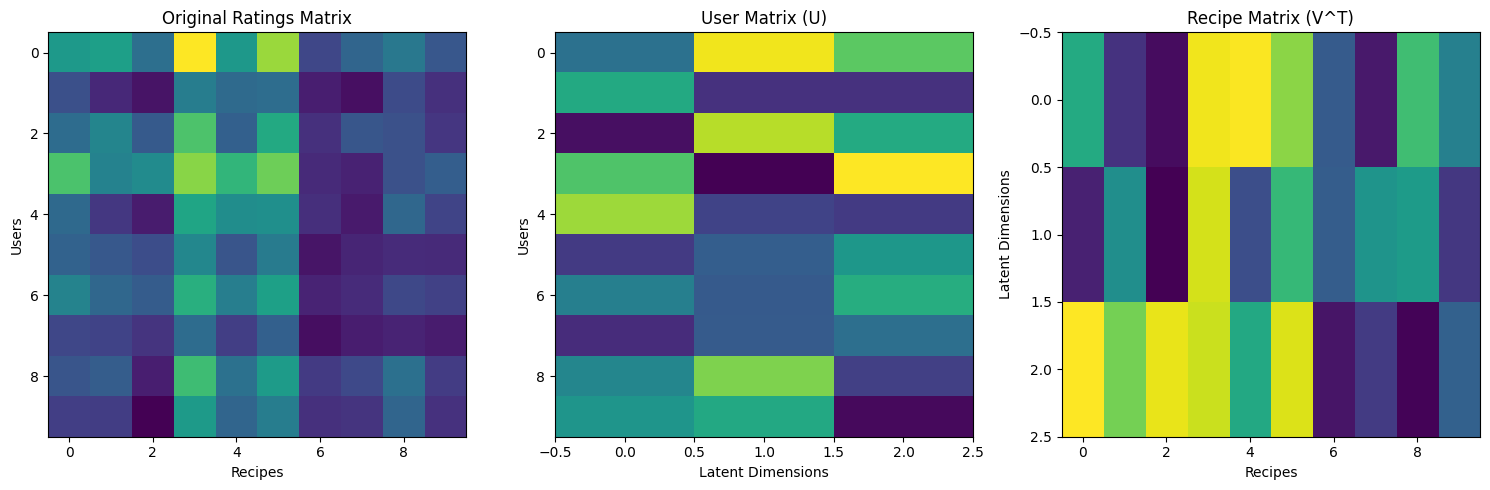

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Parameters for the synthetic illustration
users = 10  # Number of users
recipes = 10  # Number of recipes
k = 3  # Reduced dimensions

# Generate synthetic matrices
np.random.seed(42)
U = np.random.rand(users, k)  # User matrix in latent space
VT = np.random.rand(k, recipes)  # Recipe matrix in latent space

# Compute original ratings (low-rank approximation)
ratings = U.dot(VT)

# Create a figure for illustration
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original matrix (ratings matrix)
axes[0].imshow(ratings, aspect='auto', cmap='viridis')
axes[0].set_title("Original Ratings Matrix")
axes[0].set_xlabel("Recipes")
axes[0].set_ylabel("Users")

# User latent space representation
axes[1].imshow(U, aspect='auto', cmap='viridis')
axes[1].set_title("User Matrix (U)")
axes[1].set_xlabel("Latent Dimensions")
axes[1].set_ylabel("Users")

# Recipe latent space representation
axes[2].imshow(VT, aspect='auto', cmap='viridis')
axes[2].set_title("Recipe Matrix (V^T)")
axes[2].set_xlabel("Recipes")
axes[2].set_ylabel("Latent Dimensions")

# Adjust layout
plt.tight_layout()
plt.show()
